In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap,LogNorm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

import metpy.calc as mpcalc
import xwrf 

from metpy.plots import USCOUNTIES

In [2]:
### read in WRF file for domain 1
wrf_filename = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d01_2022-12-21_18:00:00"
wrfin = xr.open_dataset(wrf_filename).xwrf.postprocess()

### and d02
wrf_filename_d02 = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_18:00:00"
wrfin_d02 = xr.open_dataset(wrf_filename_d02).xwrf.postprocess()


In [3]:
subset_vars = ['wrf_projection','HGT']
wrf_subset = wrfin[subset_vars].squeeze().xwrf.destagger()
wrf_subset_d02 = wrfin_d02[subset_vars].squeeze().xwrf.destagger()

In [4]:
#### assign metpy CRS using the metadata
wrf_subset = wrf_subset.metpy.assign_crs(
    grid_mapping_name=wrf_subset.wrf_projection.attrs['grid_mapping_name'],
    latitude_of_projection_origin=wrf_subset.wrf_projection.attrs['latitude_of_projection_origin'],
    longitude_of_central_meridian=wrf_subset.wrf_projection.attrs['longitude_of_central_meridian'],
    standard_parallel=wrf_subset.wrf_projection.attrs['standard_parallel'],
    earth_radius=wrf_subset.wrf_projection.attrs['semi_major_axis']
)

wrf_subset_d02 = wrf_subset_d02.metpy.assign_crs(
    grid_mapping_name=wrf_subset_d02.wrf_projection.attrs['grid_mapping_name'],
    latitude_of_projection_origin=wrf_subset_d02.wrf_projection.attrs['latitude_of_projection_origin'],
    longitude_of_central_meridian=wrf_subset_d02.wrf_projection.attrs['longitude_of_central_meridian'],
    standard_parallel=wrf_subset_d02.wrf_projection.attrs['standard_parallel'],
    earth_radius=wrf_subset_d02.wrf_projection.attrs['semi_major_axis']
)

In [5]:
wrf_subset

<xarray.Dataset> Size: 4MB
Dimensions:         (y: 449, x: 560)
Coordinates:
    XLAT            (y, x) float32 1MB 34.57 34.58 34.58 ... 46.57 46.57 46.56
    XLONG           (y, x) float32 1MB -114.1 -114.1 -114.1 ... -94.09 -94.06
    XTIME           datetime64[ns] 8B ...
    CLAT            (y, x) float32 1MB 34.57 34.58 34.58 ... 46.57 46.57 46.56
    Time            datetime64[ns] 8B 2022-12-21T18:00:00
  * x               (x) float64 4kB -8.385e+05 -8.355e+05 ... 8.385e+05
  * y               (y) float64 4kB -6.72e+05 -6.69e+05 ... 6.69e+05 6.72e+05
    metpy_crs       object 8B Projection: lambert_conformal_conic
Data variables:
    wrf_projection  object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6370000 +...
    HGT             (y, x) float32 1MB ...
Attributes: (12/131)
    TITLE:                            OUTPUT FROM WRF V4.3 MODEL
    START_DATE:                      2022-12-21_18:00:00
    SIMULATION_START_DATE:           2022-12-21_18:00:00
    WEST-EAST_GRID_DIMENSION:        561
    SOUTH-NORTH_GRID_DIMENSION:      450
    BOTTOM-TOP_GRID_DIMENSION:       86
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

### set up a dummy map on domain 2 to get extent 

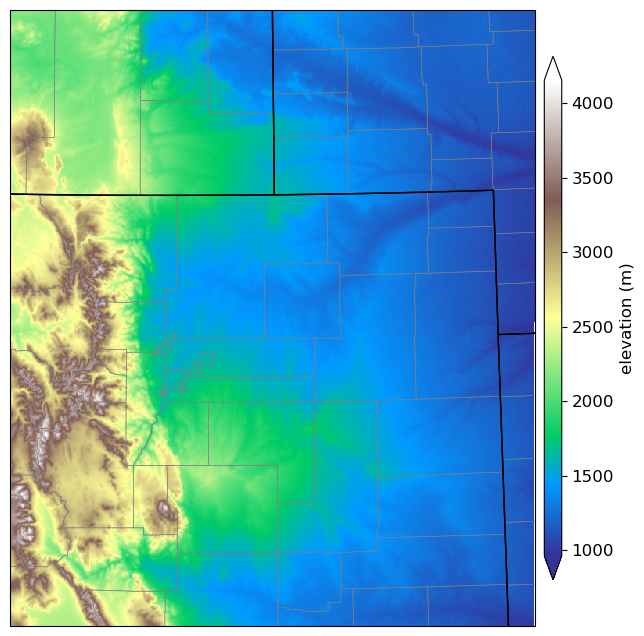

In [6]:
### set projection
crs2 = ccrs.LambertConformal(central_longitude=wrf_subset_d02.wrf_projection.attrs['longitude_of_central_meridian'], 
                            central_latitude=wrf_subset_d02.wrf_projection.attrs['latitude_of_projection_origin'])

fig = plt.figure(figsize=(12,8))
#add_metpy_logo(fig, 1775, 170, size='large')
ax2 = fig.add_subplot(1, 1, 1, projection=crs2)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND.with_scale('10m'))
ax2.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax2.add_feature(cfeature.STATES.with_scale('10m'))
ax2.add_feature(cfeature.BORDERS.with_scale('10m'))

dem = ax2.pcolormesh(
    wrf_subset_d02.XLONG,
    wrf_subset_d02.XLAT,
    wrf_subset_d02.HGT,
    cmap=plt.cm.terrain,
    #norm=LogNorm(vmin=1, vmax=3000),
    #transform_first=True,
    shading='auto',
    transform=ccrs.PlateCarree())

cb = plt.colorbar(dem, orientation='vertical', pad=0.01,
                  extend='both',
                  shrink=0.85, aspect=30)
cb.set_label('elevation (m)', fontsize=12)
#cb.ax.locator_params(nbins=20)
cb.ax.tick_params(labelsize=12)

plt.show()


In [8]:
minlon_d02 = wrf_subset_d02.sel(x=ax2.get_extent()[0],y=ax2.get_extent()[2], method='nearest')['XLONG'].item()
minlat_d02 = wrf_subset_d02.sel(x=ax2.get_extent()[0],y=ax2.get_extent()[2], method='nearest')['XLAT'].item()
maxlon_d02 = wrf_subset_d02.sel(x=ax2.get_extent()[1],y=ax2.get_extent()[3], method='nearest')['XLONG'].item()
maxlat_d02 = wrf_subset_d02.sel(x=ax2.get_extent()[1],y=ax2.get_extent()[3], method='nearest')['XLAT'].item()

print(minlon_d02,minlat_d02,maxlon_d02,maxlat_d02)


-106.39932250976562 38.02963638305664 -101.61471557617188 42.224945068359375


### make map

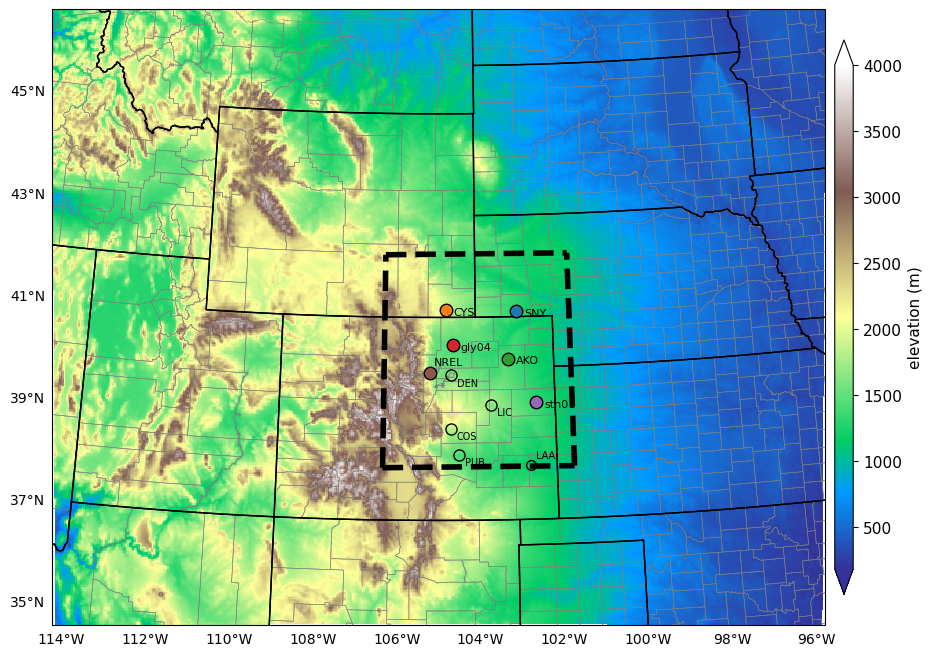

In [15]:
### set projection
crs = ccrs.LambertConformal(central_longitude=wrf_subset.wrf_projection.attrs['longitude_of_central_meridian'], 
                            central_latitude=wrf_subset.wrf_projection.attrs['latitude_of_projection_origin'])

fig = plt.figure(figsize=(12,8))
#add_metpy_logo(fig, 1775, 170, size='large')
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Set plot bounds -- or just comment this out if wanting to plot the full domain
#ax.set_extent((-110, -100, 37., 42.5))
#ax.set_extent((-88.5, -80.5, 35,39.25))

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))

dem = ax.pcolormesh(
    wrf_subset.XLONG,
    wrf_subset.XLAT,
    wrf_subset.HGT,
    cmap=plt.cm.terrain,
    #norm=LogNorm(vmin=1, vmax=3000),
    #transform_first=True,
    shading='auto',
    transform=ccrs.PlateCarree())

cb = plt.colorbar(dem, orientation='vertical', pad=0.01,
                  extend='both',
                  shrink=0.9, aspect=30)
cb.set_label('elevation (m)', fontsize=11)
#cb.ax.locator_params(nbins=20)
cb.ax.tick_params(labelsize=11)

### add box for nested grid
ax.plot([minlon_d02, minlon_d02], [minlat_d02, maxlat_d02],color='black', linewidth=4,
        linestyle='dashed',transform=ccrs.PlateCarree())
ax.plot([maxlon_d02, maxlon_d02], [minlat_d02, maxlat_d02],color='black', linewidth=4,
        linestyle='dashed',transform=ccrs.PlateCarree())       
ax.plot([minlon_d02, maxlon_d02], [minlat_d02, minlat_d02],color='black', linewidth=4,
        linestyle='dashed',transform=ccrs.PlateCarree())  
ax.plot([minlon_d02, maxlon_d02], [maxlat_d02, maxlat_d02],color='black', linewidth=4,
        linestyle='dashed',transform=ccrs.PlateCarree())

# Add the gridlines
#### find min/max lon/lat for this grid
minlon = wrf_subset.sel(x=ax.get_extent()[0],y=ax.get_extent()[2], method='nearest')['XLONG'].item()
minlat = wrf_subset.sel(x=ax.get_extent()[0],y=ax.get_extent()[2], method='nearest')['XLAT'].item()
maxlon = wrf_subset.sel(x=ax.get_extent()[1],y=ax.get_extent()[3], method='nearest')['XLONG'].item()
maxlat = wrf_subset.sel(x=ax.get_extent()[1],y=ax.get_extent()[3], method='nearest')['XLAT'].item()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 x_inline=False, y_inline=False, rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator(np.arange(np.round(minlon,0), np.round(maxlon,0), 2.0))
gl.ylocator = mticker.FixedLocator(np.arange(np.round(minlat,0), np.round(maxlat,0), 2.0))
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.ylabel_style = {'size': 10, 'color': 'black'}
gl.xlabel_style = {'size': 10, 'color': 'black'}

### add markers at locations
lats = [41.0997608, 41.1556389, 40.1756389, 40.4487, 39.2987]
lons = [-102.9849931, -104.8104722,-103.2220278, -104.6380, -102.5220]
cities = ["SNY", "CYS", "AKO", "gly04", "stn01"]
for i in range(0,len(cities)):
    ax.plot(lons[i], lats[i], 
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
           marker='o', markersize=9, markeredgecolor='black',
            transform=ccrs.PlateCarree())
    ax.text(lons[i] + 0.2,lats[i]-0.1, cities[i], 
            fontsize=8, horizontalalignment='left',
            transform=ccrs.PlateCarree())

### and NREL displaced upward a bit
lats = [39.9106]
lons = [-105.2347]
cities = ["NREL"]
for i in range(0,len(cities)):
    ax.plot(lons[i], lats[i], 
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][5],
           marker='o', markersize=9, markeredgecolor='black',
            transform=ccrs.PlateCarree())
    ax.text(lons[i] + 0.12,lats[i]+0.15, cities[i], 
            fontsize=8, horizontalalignment='left',
            transform=ccrs.PlateCarree())

### and do the other stations that don't need a color fill
lats = [38.8017,39.8563,39.274,38.2837]
lons = [-104.7026,-104.6764,-103.666,-104.4952]
cities = ["COS","DEN","LIC","PUB"]
for i in range(0,len(cities)):
    ax.plot(lons[i], lats[i], 
            markerfacecolor='none',
           marker='o', markersize=8, markeredgecolor='black',
            transform=ccrs.PlateCarree())
    ax.text(lons[i] + 0.15,lats[i]-0.2, cities[i], 
            fontsize=7, horizontalalignment='left',
            transform=ccrs.PlateCarree())

### and LAA so it isn't covered by the box
lats = [38.07698]
lons = [-102.69557]
cities = ["LAA"]
for i in range(0,len(cities)):
    ax.plot(lons[i], lats[i], 
            markerfacecolor='none',
           marker='o', markersize=7, markeredgecolor='black',
            transform=ccrs.PlateCarree())
    ax.text(lons[i] + 0.12,lats[i]+0.12, cities[i], 
            fontsize=7, horizontalalignment='left',
            transform=ccrs.PlateCarree())

fig.savefig("wrf_domains_stations_2022122118.png", dpi=300,
           transparent=False, bbox_inches='tight', facecolor='white')
    
plt.show()

plt.close('all')